In [1]:
import pandas as pd
import numpy as np

# Load merged evaluation results and predictions
eval_df = pd.read_csv("../results/all_runs/evaluation_results.csv")
eval_df = eval_df[eval_df["algorithm"] != "ProteomicsRandomForest"]

# Use only prediction rows
eval_df = eval_df[eval_df["rand_setting"] == "predictions"]

# Compute means and stds
melted = eval_df.melt(
    id_vars=["algorithm", "test_mode", "CV_split"],
    value_vars=["MSE", "R^2", "Pearson", "R^2: normalized", "Pearson: normalized"],
    var_name="metric",
)
melted["mean"] = melted.groupby(["algorithm", "test_mode", "metric"])["value"].transform("mean")
melted["std"] = melted.groupby(["algorithm", "test_mode", "metric"])["value"].transform("std")
melted = melted.drop(columns=["CV_split", "value"]).drop_duplicates()

# Pivot to wide format
means = melted.pivot(index=["algorithm", "test_mode"], columns="metric", values="mean").reset_index()
stds = melted.pivot(index=["algorithm", "test_mode"], columns="metric", values="std").reset_index()
results = pd.merge(means, stds, on=["algorithm", "test_mode"], suffixes=("", "_std"))

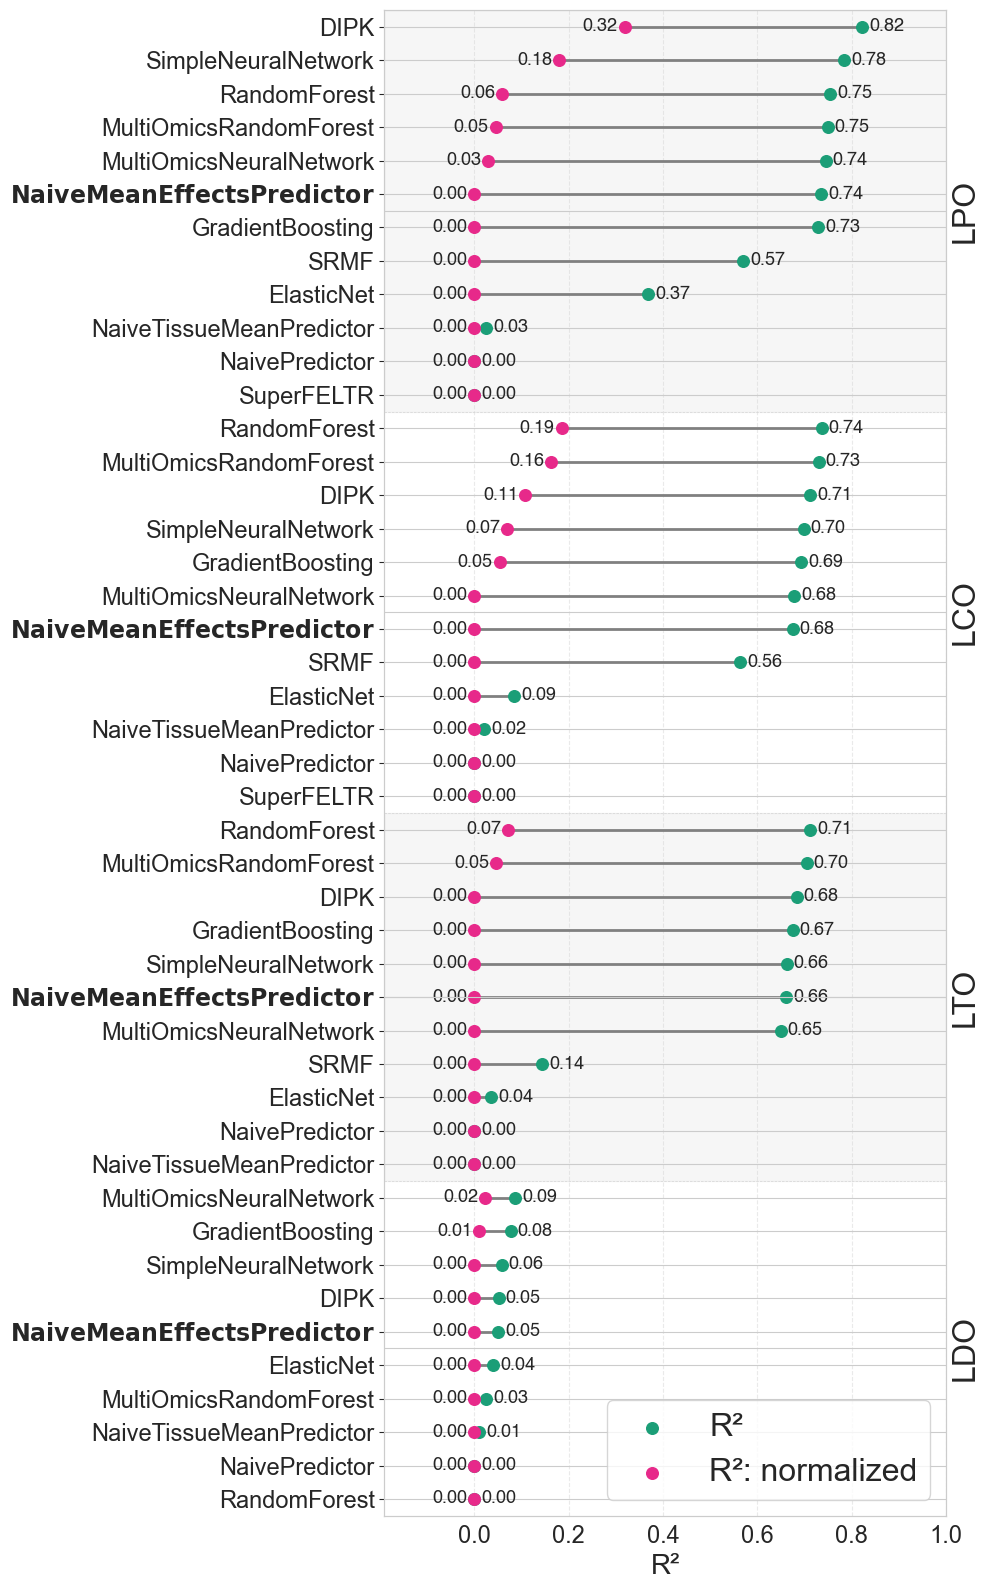

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import cycle

# Font size adder
FONT_SIZE_ADDER = 5

# Copy and rename
res = results.copy()
res.rename(columns={"algorithm": "Model", "LPO_LCO_LDO": "test_mode"}, inplace=True)

# Filter out unwanted models
exclude_models = ["SingleDrugProteomicsElasticNet", "NaiveCellLineMeanPredictor", "NaiveDrugMeanPredictor"]
res = res[~res["Model"].isin(exclude_models)]

# Keep only relevant metrics and clip negatives
r2_data = res[["Model", "test_mode", "R^2", "R^2: normalized"]].copy()
r2_data[["R^2", "R^2: normalized"]] = r2_data[["R^2", "R^2: normalized"]].clip(lower=0)

# Set validation scheme order (now including LTO)
validation_order = ["LPO", "LCO", "LTO", "LDO"]
r2_data["test_mode"] = pd.Categorical(r2_data["test_mode"], categories=validation_order, ordered=True)

# Aggregate to one row per (Validation Scheme, Model)
agg_df = r2_data.groupby(["test_mode", "Model"], observed=True)[["R^2", "R^2: normalized"]].mean().reset_index()

# Sort models within each validation scheme by R²
sorted_blocks = []
for val in validation_order:
    block = agg_df[agg_df["test_mode"] == val].copy()
    block = block.sort_values(by="R^2", ascending=False)
    sorted_blocks.append(block)

pivot_df = pd.concat(sorted_blocks, ignore_index=True)

# Reverse so LPO is at the top in y-axis
pivot_df = pivot_df[::-1].reset_index(drop=True)
pivot_df["y_label"] = pivot_df["Model"].apply(lambda x: r"$\bf{" + x + "}$" if x == "NaiveMeanEffectsPredictor" else x)


# Plot
fig, ax = plt.subplots(figsize=(10, 16))

for i, row in pivot_df.iterrows():
    ax.plot([row["R^2"], row["R^2: normalized"]], [i, i], color="gray", linewidth=2, zorder=1)
    ax.scatter(row["R^2"], i, color="#1b9e77", s=70, label="R²" if i == 0 else "", zorder=2)
    ax.scatter(row["R^2: normalized"], i, color="#e7298a", s=70, label="R²: normalized" if i == 0 else "", zorder=3)

    ax.text(
        row["R^2"] + 0.015,
        i,
        f"{row['R^2']:.2f}",
        ha="left",
        va="center",
        fontsize=8 + FONT_SIZE_ADDER,
        fontfamily="Helvetica",
    )
    ax.text(
        row["R^2: normalized"] - 0.015,
        i,
        f"{row['R^2: normalized']:.2f}",
        ha="right",
        va="center",
        fontsize=8 + FONT_SIZE_ADDER,
        fontfamily="Helvetica",
    )


# Background shading by validation group
shade_color = cycle(["lightgrey", "white"])
for val in validation_order:
    mask = pivot_df["test_mode"] == val
    if not mask.any():
        continue
    indices = pivot_df.index[mask]
    start = indices.min()
    end = indices.max()
    ax.axhspan(
        start - 0.5,
        end + 0.5,
        xmin=0.0,
        xmax=1.0,
        color=next(shade_color),
        alpha=0.2,
        zorder=0,
        transform=ax.get_yaxis_transform(),
    )


# Horizontal group separator lines
group_ends = pivot_df["test_mode"].ne(pivot_df["test_mode"].shift()).cumsum()
separators = group_ends.value_counts(sort=False).cumsum().tolist()[:-1]
for pos in separators:
    ax.axhline(pos - 0.5, color="lightgray", linestyle="--", linewidth=0.5)

# Styling
# ax.axvline(0, color='red', linestyle='--', linewidth=1, alpha=0.8)
ax.set_yticks(range(len(pivot_df)))
ax.set_yticklabels(pivot_df["y_label"], fontsize=14 + FONT_SIZE_ADDER)
ax.set_xlabel("R²", fontsize=15 + FONT_SIZE_ADDER)
ax.tick_params(axis="both", which="major", labelsize=12 + FONT_SIZE_ADDER)
ax.legend(fontsize=18 + FONT_SIZE_ADDER)
ax.grid(True, axis="x", linestyle="--", alpha=0.4)
ax.set_ylim(-0.5, len(pivot_df) - 0.5)
ax.set_xlim(-0.19, 1.0)

# Right-hand y-axis for validation scheme labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

group_labels = [val for val in validation_order if val in pivot_df["test_mode"].unique()]
group_positions = [pivot_df[pivot_df["test_mode"] == val].index.to_numpy().mean() for val in group_labels]

ax2.set_yticks(group_positions)
ax2.set_yticklabels(group_labels, fontsize=19 + FONT_SIZE_ADDER, rotation=90, va="center", ha="left")
ax2.tick_params(axis="y", which="both", length=0, labelsize=18 + FONT_SIZE_ADDER)

plt.tight_layout()
plt.savefig("figures/r2_dumbbell_plot.pdf", bbox_inches="tight", dpi=300)



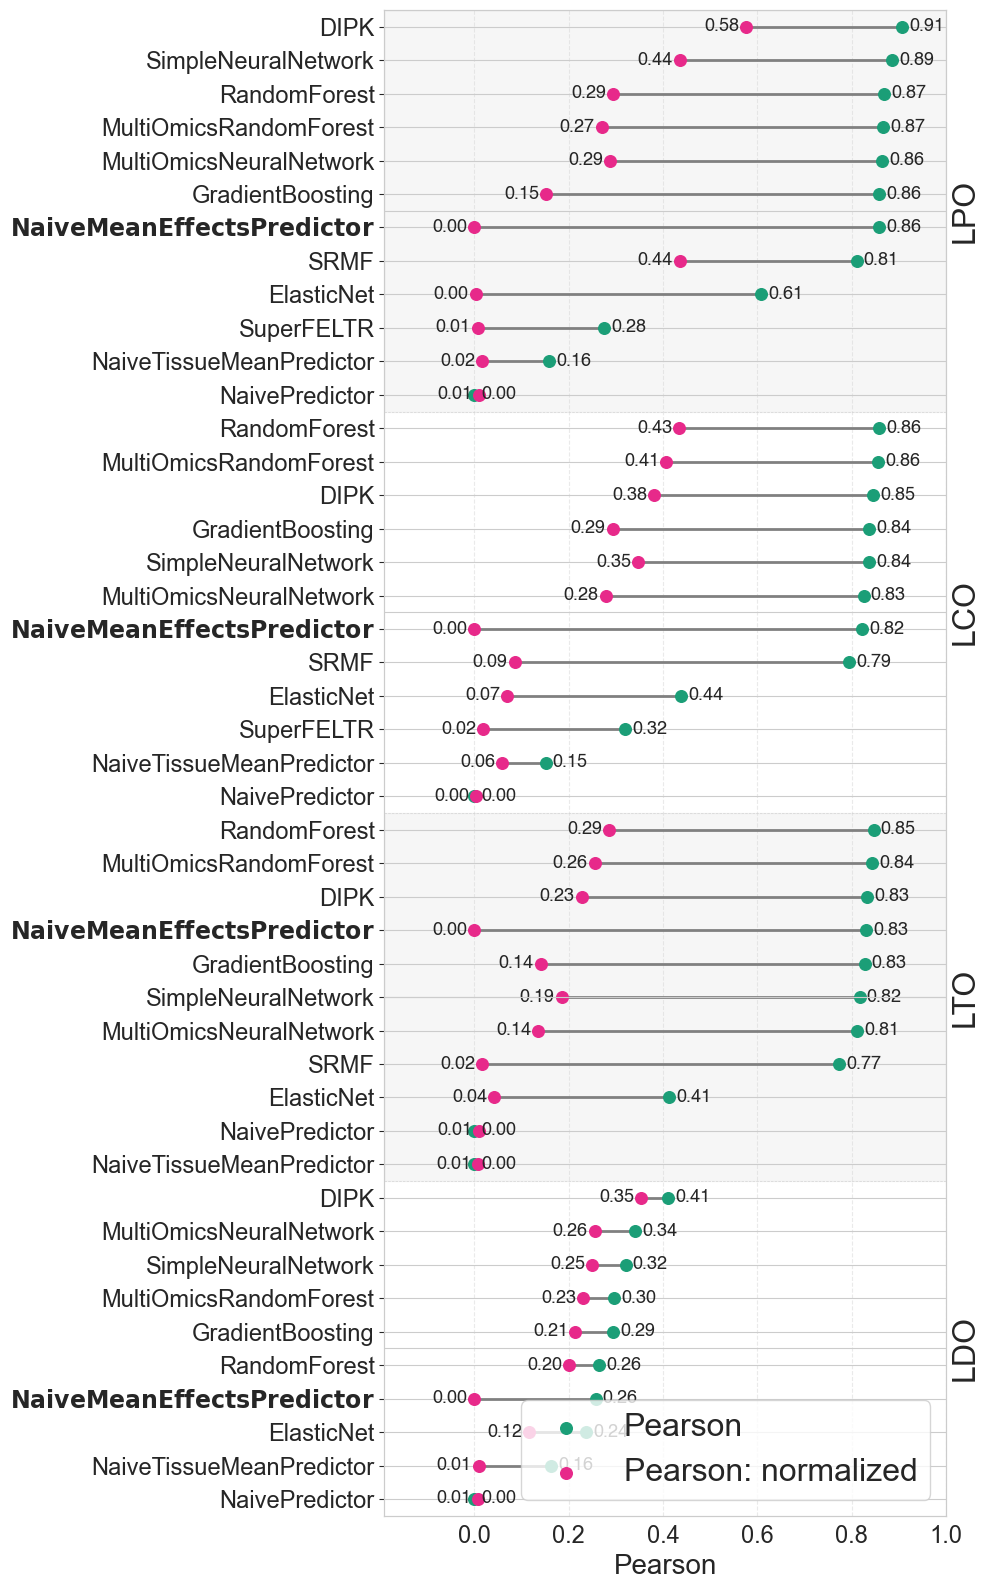

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import cycle

# Set your metric here
METRIC = "Pearson"

# Font size adder
FONT_SIZE_ADDER = 5

# Copy and rename
res = results.copy()
res.rename(columns={"algorithm": "Model", "LPO_LCO_LDO": "test_mode"}, inplace=True)

# Filter out unwanted models
exclude_models = ["SingleDrugProteomicsElasticNet", "NaiveCellLineMeanPredictor", "NaiveDrugMeanPredictor"]
res = res[~res["Model"].isin(exclude_models)]

# Clip values if necessary
metric_data = res[["Model", "test_mode", METRIC, f"{METRIC}: normalized"]].copy()
metric_data[[METRIC, f"{METRIC}: normalized"]] = metric_data[[METRIC, f"{METRIC}: normalized"]].clip(lower=0)

# Set validation scheme order
validation_order = ["LPO", "LCO", "LTO", "LDO"]
metric_data["test_mode"] = pd.Categorical(metric_data["test_mode"], categories=validation_order, ordered=True)

# Aggregate mean per group
agg_df = (
    metric_data.groupby(["test_mode", "Model"], observed=True)[[METRIC, f"{METRIC}: normalized"]].mean().reset_index()
)

# Sort models within each validation scheme by metric
sorted_blocks = []
for val in validation_order:
    block = agg_df[agg_df["test_mode"] == val].copy()
    block = block.sort_values(by=METRIC, ascending=False)
    sorted_blocks.append(block)

pivot_df = pd.concat(sorted_blocks, ignore_index=True)

# Reverse so LPO is at top
pivot_df = pivot_df[::-1].reset_index(drop=True)
pivot_df["y_label"] = pivot_df["Model"].apply(lambda x: r"$\bf{" + x + "}$" if x == "NaiveMeanEffectsPredictor" else x)

# Plot
fig, ax = plt.subplots(figsize=(10, 16))

for i, row in pivot_df.iterrows():
    ax.plot([row[METRIC], row[f"{METRIC}: normalized"]], [i, i], color="gray", linewidth=2, zorder=1)
    ax.scatter(row[METRIC], i, color="#1b9e77", s=70, label=METRIC if i == 0 else "", zorder=2)
    ax.scatter(
        row[f"{METRIC}: normalized"],
        i,
        color="#e7298a",
        s=70,
        label=f"{METRIC}: normalized" if i == 0 else "",
        zorder=3,
    )

    ax.text(
        row[METRIC] + 0.015,
        i,
        f"{row[METRIC]:.2f}",
        ha="left",
        va="center",
        fontsize=8 + FONT_SIZE_ADDER,
        fontfamily="Helvetica",
    )
    ax.text(
        row[f"{METRIC}: normalized"] - 0.015,
        i,
        f"{row[f'{METRIC}: normalized']:.2f}",
        ha="right",
        va="center",
        fontsize=8 + FONT_SIZE_ADDER,
        fontfamily="Helvetica",
    )

# Background shading
shade_color = cycle(["lightgrey", "white"])
for val in validation_order:
    mask = pivot_df["test_mode"] == val
    if not mask.any():
        continue
    indices = pivot_df.index[mask]
    start = indices.min()
    end = indices.max()
    ax.axhspan(
        start - 0.5,
        end + 0.5,
        xmin=0.0,
        xmax=1.0,
        color=next(shade_color),
        alpha=0.2,
        zorder=0,
        transform=ax.get_yaxis_transform(),
    )

# Separator lines
group_ends = pivot_df["test_mode"].ne(pivot_df["test_mode"].shift()).cumsum()
separators = group_ends.value_counts(sort=False).cumsum().tolist()[:-1]
for pos in separators:
    ax.axhline(pos - 0.5, color="lightgray", linestyle="--", linewidth=0.5)

# Styling
ax.set_yticks(range(len(pivot_df)))
ax.set_yticklabels(pivot_df["y_label"], fontsize=14 + FONT_SIZE_ADDER)
ax.set_xlabel(METRIC, fontsize=15 + FONT_SIZE_ADDER)
ax.tick_params(axis="both", which="major", labelsize=12 + FONT_SIZE_ADDER)
ax.legend(fontsize=18 + FONT_SIZE_ADDER, loc="lower right")
ax.grid(True, axis="x", linestyle="--", alpha=0.4)
ax.set_ylim(-0.5, len(pivot_df) - 0.5)
ax.set_xlim(-0.19, 1.0)

# Right-hand y-axis for validation scheme labels
ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())

group_labels = [val for val in validation_order if val in pivot_df["test_mode"].unique()]
group_positions = [pivot_df[pivot_df["test_mode"] == val].index.to_numpy().mean() for val in group_labels]

ax2.set_yticks(group_positions)
ax2.set_yticklabels(group_labels, fontsize=19 + FONT_SIZE_ADDER, rotation=90, va="center", ha="left")
ax2.tick_params(axis="y", which="both", length=0, labelsize=18 + FONT_SIZE_ADDER)

plt.tight_layout()
plt.savefig(f"figures/{METRIC.lower()}_dumbbell_plot.pdf", bbox_inches="tight", dpi=300)


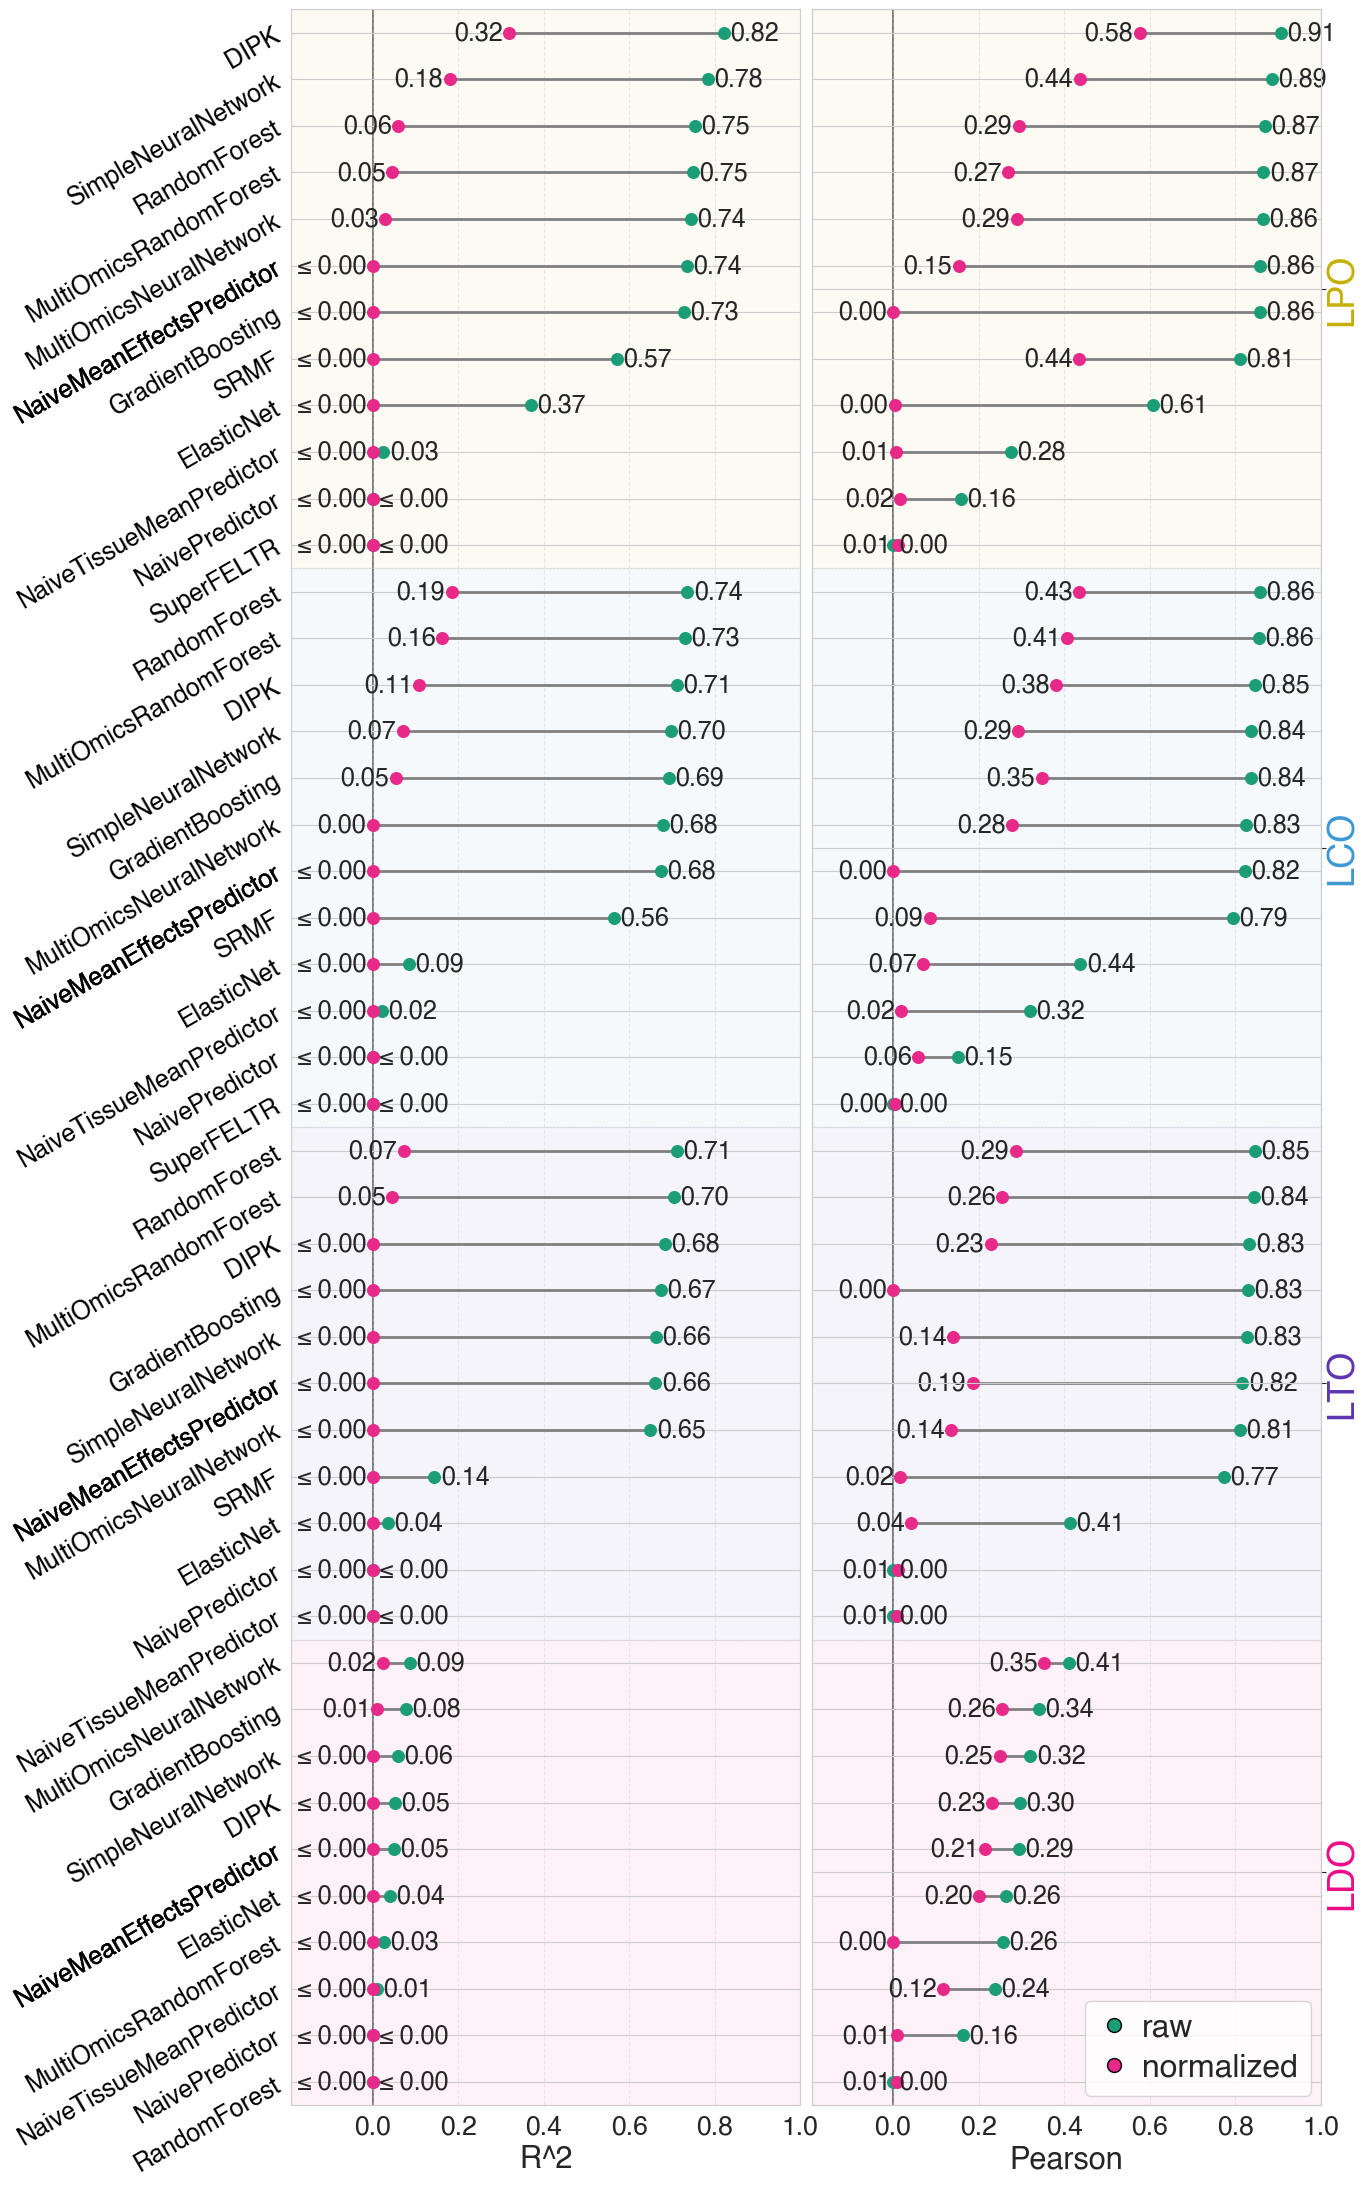

In [4]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "Helvetica"

FONT_SIZE_ADDER = 7
validation_shade_colors = {
    "LPO": "#C6B004",
    "LCO": "#3D98D3",
    "LDO": "#EC0B88",
    "LTO": "#5E35B1",
}

metrics = ["R^2", "Pearson"]
validation_order = ["LPO", "LCO", "LTO", "LDO"]
exclude_models = ["SingleDrugProteomicsElasticNet", "NaiveCellLineMeanPredictor", "NaiveDrugMeanPredictor"]

# Prepare data
res = results.copy()
res.rename(columns={"algorithm": "Model", "LPO_LCO_LDO": "test_mode"}, inplace=True)
res = res[~res["Model"].isin(exclude_models)]


def process_metric(df, metric):
    df = df[["Model", "test_mode", metric, f"{metric}: normalized"]].copy()
    df[[metric, f"{metric}: normalized"]] = df[[metric, f"{metric}: normalized"]].clip(lower=0)
    df["test_mode"] = pd.Categorical(df["test_mode"], categories=validation_order, ordered=True)
    agg = df.groupby(["test_mode", "Model"], observed=True)[[metric, f"{metric}: normalized"]].mean().reset_index()
    sorted_blocks = []
    for val in validation_order:
        block = agg[agg["test_mode"] == val].copy()
        block = block.sort_values(by=metric, ascending=False)
        sorted_blocks.append(block)
    final = pd.concat(sorted_blocks, ignore_index=True)
    final = final[::-1].reset_index(drop=True)
    return final


pivot_r2 = process_metric(res, "R^2")
pivot_pearson = process_metric(res, "Pearson")

yticks = range(len(pivot_r2))
model_names = pivot_r2["Model"].tolist()

fig, axes = plt.subplots(1, 2, figsize=(13.8, 22), sharey=True)

for ax, pivot_df, METRIC in zip(axes, [pivot_r2, pivot_pearson], metrics):
    for i, row in pivot_df.iterrows():
        ax.plot([row[METRIC], row[f"{METRIC}: normalized"]], [i, i], color="gray", linewidth=2, zorder=1)
        ax.scatter(row[METRIC], i, color="#1b9e77", s=70, label=METRIC if i == 0 else "", zorder=2)
        ax.scatter(
            row[f"{METRIC}: normalized"],
            i,
            color="#e7298a",
            s=70,
            label=f"{METRIC}: normalized" if i == 0 else "",
            zorder=3,
        )

        def format_val(val, metric):
            if metric == "R^2" and val == 0:
                return "≤ 0.00"
            return f"{val:.2f}"

        # In your plotting loop:
        ax.text(
            row[METRIC] + 0.015,
            i,
            format_val(row[METRIC], METRIC),
            ha="left",
            va="center",
            fontsize=11 + FONT_SIZE_ADDER,
            fontfamily="Helvetica",
        )

        ax.text(
            row[f"{METRIC}: normalized"] - 0.015,
            i,
            format_val(row[f"{METRIC}: normalized"], METRIC),
            ha="right",
            va="center",
            fontsize=11 + FONT_SIZE_ADDER,
            fontfamily="Helvetica",
        )

    for val in validation_order:
        mask = pivot_df["test_mode"] == val
        if not mask.any():
            continue
        indices = pivot_df.index[mask]
        start = indices.min()
        end = indices.max()
        shade = validation_shade_colors.get(val, "#f0f0f0")
        ax.axhspan(
            start - 0.5,
            end + 0.5,
            xmin=0.0,
            xmax=1.0,
            color=shade,
            alpha=0.05,
            zorder=0,
            transform=ax.get_yaxis_transform(),
        )

    # Separator lines
    group_ends = pivot_df["test_mode"].ne(pivot_df["test_mode"].shift()).cumsum()
    separators = group_ends.value_counts(sort=False).cumsum().tolist()[:-1]
    for pos in separators:
        ax.axhline(pos - 0.5, color="lightgray", linestyle="--", linewidth=0.5)

    ax.set_xlim(-0.19, 1.0)
    ax.grid(True, axis="x", linestyle="--", alpha=0.4)
    ax.set_xlabel(METRIC, fontsize=15 + FONT_SIZE_ADDER)
    ax.set_yticks(yticks)
    ax.tick_params(axis="both", which="major", labelsize=12 + FONT_SIZE_ADDER)
    for y in yticks:
        ax.axhline(y, color="gray", linestyle=":", linewidth=0.5, alpha=0.4, zorder=0)
axes[0].axvline(0, color="black", linestyle="-", linewidth=1.2, zorder=0, alpha=0.6)
axes[1].axvline(0, color="black", linestyle="-", linewidth=1.2, zorder=0, alpha=0.6)

# Turn off y-axis labels and ticks on both
axes[0].set_yticklabels([])
axes[1].set_yticklabels([])

# Manually add model names on the left of the left plot
for i, name in enumerate(model_names):
    if name == "NaiveMeanEffectsPredictor":
        # Draw twice with slight offset for "faux bold"
        axes[0].text(
            -0.220,
            i,
            name,
            ha="right",
            va="center",
            fontsize=11 + FONT_SIZE_ADDER,
            fontfamily="Helvetica",
            color="black",
            rotation=30,
            rotation_mode="anchor",
        )

        axes[0].text(
            -0.221,
            i,
            name,
            ha="right",
            va="center",
            fontsize=11 + FONT_SIZE_ADDER,
            fontfamily="Helvetica",
            color="black",
            rotation=30,
            rotation_mode="anchor",
        )
        axes[0].text(
            -0.219,
            i,
            name,
            ha="right",
            va="center",
            fontsize=11 + FONT_SIZE_ADDER,
            fontfamily="Helvetica",
            color="black",
            rotation=30,
            rotation_mode="anchor",
        )
    else:
        axes[0].text(
            -0.22,
            i,
            name,
            ha="right",
            va="center",
            fontsize=11 + FONT_SIZE_ADDER,
            fontfamily="Helvetica",
            color="black",
            rotation=30,
            rotation_mode="anchor",
        )


axes[0].set_ylim(-0.5, len(model_names) - 0.5)
axes[1].set_ylim(-0.5, len(model_names) - 0.5)
axes[1].tick_params(axis="y", length=0)  # removes the tick lines

# Right-side group labels
ax2 = axes[1].twinx()
ax2.set_ylim(-0.5, len(model_names) - 0.5)
group_labels = [val for val in validation_order if val in pivot_r2["test_mode"].unique()]
group_positions = [pivot_r2[pivot_r2["test_mode"] == val].index.to_numpy().mean() for val in group_labels]
ax2.set_yticks(group_positions)
ax2.set_yticklabels([])
for label, pos in zip(group_labels, group_positions):
    ax2.text(
        1.01,
        pos,
        label,
        transform=ax2.get_yaxis_transform(),
        fontsize=19 + FONT_SIZE_ADDER,
        fontfamily="Helvetica",
        rotation=90,
        va="center",
        ha="left",
        color=validation_shade_colors[label],
    )


custom_legend = [
    Line2D([0], [0], marker="o", color="none", label="raw", markerfacecolor="#1b9e77", markersize=10),
    Line2D([0], [0], marker="o", color="none", label="normalized", markerfacecolor="#e7298a", markersize=10),
]

axes[1].legend(
    handles=custom_legend,
    loc="lower right",
    handletextpad=0.4,
    handlelength=1.0,
    borderaxespad=0.3,
    labelspacing=0.3,
    prop={"family": "Helvetica", "size": 16 + FONT_SIZE_ADDER},
)


plt.tight_layout(h_pad=0.001, w_pad=-0.5)
plt.savefig("figures/r2_pearson_dumbbell.pdf", bbox_inches="tight", dpi=300)
plt.show()

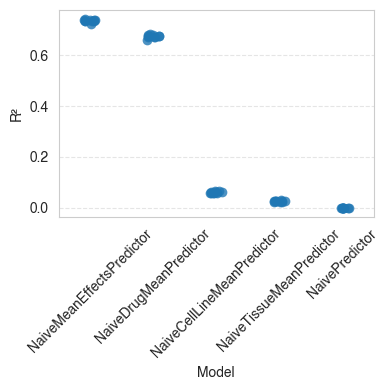

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

naive_r2 = eval_df[
    (eval_df["algorithm"].str.startswith("Naive"))
    & (eval_df["rand_setting"] == "predictions")
    & (eval_df["test_mode"] == "LPO")
][["algorithm", "R^2"]].copy()
# Compute mean R² per model for sorting
model_order = naive_r2.groupby("algorithm")["R^2"].mean().sort_values(ascending=False).index.tolist()

# Plot beeswarm-style stripplot
plt.figure(figsize=(4, 4))
sns.stripplot(data=naive_r2, x="algorithm", y="R^2", order=model_order, jitter=True, alpha=0.8, size=7)
plt.xlabel("Model")
plt.ylabel("R²")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Compute mean and standard error
summary_df = naive_r2.groupby("algorithm")["R^2"].agg(["mean", "sem"]).rename(columns={"mean": "R^2", "sem": "SE"})

# Round for display
summary_df = summary_df.round(3)

# Insert empty row for NaiveTissueMeanPredictor
summary_df.loc["NaiveTissueMeanPredictor"] = [None, None]

# Sort again to keep original ordering
summary_df = summary_df.loc[model_order + ["NaiveTissueMeanPredictor"]]

# Convert to LaTeX
latex_table = summary_df.reset_index().to_latex(
    index=False,
    float_format="%.3f",
    na_rep="",
    caption="Mean R² and standard error for Naive baseline models evaluated in the LPO setting.",
    label="tab:naive_r2_lpo",
    column_format="llr",
    longtable=False,
    bold_rows=False,
    escape=False,
    multicolumn=False,
    multicolumn_format="c",
)

print(latex_table)